In [2]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import seaborn as sns
import pandas as pd
import os, glob, math, re, gzip, skbio, time
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings
from Bio import Entrez
warnings.filterwarnings('ignore')
Entrez.email = "ajaffe@stanford.edu"

In [3]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [4]:
import sys
sys.path.insert(0, '/home/users/ajaffe/notebooks/modules/')
import parse

In [5]:
rootdir = "/scratch/users/ajaffe/photoeco/"
deepeco = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir)

# read in data

In [5]:
genomes = pd.read_csv(rootdir + "genome_table.tsv", sep="\t")
genomes.head()

,genome_name,lineage,checkm_completeness,checkm_redundancy,cluster95,cluster99
0,2626541517,AMZ IB,56.79,6.11,5_1,5_5
1,2626541518,AMZ IB,60.34,6.90,5_1,5_10
2,2626541532,AMZ IB,65.62,2.72,5_1,5_14
3,2626541536,AMZ IB,50.14,5.10,5_1,5_17
4,2818991511,AMZ II,74.64,0.27,4_1,4_4


In [6]:
genomes[genomes["lineage"].str.contains("AMZ")].sort_values("checkm_completeness", 
                                                            ascending=False).drop_duplicates("lineage")

,genome_name,lineage,checkm_completeness,checkm_redundancy,cluster95,cluster99
381,SRR4465026.100.83,AMZ III,99.18,0.68,10_1,10_1
348,SRR11923207.100.13,AMZ IB,93.84,0.27,5_1,5_6
356,SRR12424656.100.10,AMZ IA,92.80,3.00,5_2,5_23
374,SRR25584950.100.49,AMZ II,87.38,1.22,4_1,4_5


In [7]:
rubiscos = pd.read_csv(rootdir + "rubisco_table.tsv", sep="\t")
rubiscos["dataset"] = "cyano"
rubiscos.head()

,gene,hmm,scaffold,genome_name,lineage,protein_sequence,dataset
0,OceanDNA-b16234_00052_2,II,OceanDNA-b16234_00052,OceanDNA-b16234,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano
1,ERR868457.100.1_contig_163_1,II,ERR868457.100.1_contig_163,ERR868457.100.1,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano
2,JASLWS010000001.1_45,II,JASLWS010000001.1,GCA_030740755.1_ASM3074075v1_genomic,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano
3,JASLTS010000061.1_1,II,JASLTS010000061.1,GCA_030742835.1_ASM3074283v1_genomic,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano
4,Ga0078703_1006_31,II,Ga0078703_1006,2626541517,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano


# rubisco gene tree

In [39]:
cmdir(rootdir + "rubisco/phylo")

### gather references

In [10]:
# liu et al (not all match btwn tables bc of ambiguities)
sequences = pd.read_csv(rootdir + "liu_sequences.csv").rename(columns={"Name": "Organism"})
states = pd.read_csv(rootdir + "liu_states.csv")
liu = sequences.merge(states[["Organism", "oligomeric_state"]], how="left", on="Organism").fillna("None")
liu.columns = ["gene", "genome_name", "protein_sequence", "oligomeric_state"]
liu["dataset"] = "liu"
liu.sort_values("oligomeric_state",ascending=False).head(2)

,gene,genome_name,protein_sequence,oligomeric_state,dataset
169,RBC4.13,Sulfurivirga caldicuralii,MDQSNRYANLDLKEEDLINGGRHMLVAYRMKPAPGYGFLEVAAHIA...,tetramer,liu
118,RBC.1,Thiocystis violascens,MALDQSARYSDLSLTEADLIAGGKHILVAYKMKPKGGIGYLEAAAH...,hexamer,liu


In [ ]:
# davidi et all
davidi = pd.read_csv(rootdir + "davidi_sequences.csv").dropna(how="all", axis=1)
davidi.columns = ["gene", "form", "rate_mean", "rate_std", "soluble", 
                  "protein_sequence", "dna_sequence", "genome_name"]
davidi["dataset"] = "davidi"
davidi.head(2)

In [11]:
# prywes at al
prywes = pd.read_csv("/home/groups/dekas/ajaffe/hmms/rubisco/" + \
                     "File_S3_Rubisco_sequence_table.csv").drop(["Unnamed: 0"], axis=1).query("Form=='II'")
prywes = prywes[["NCBI_Accession_ID", "Form", "Species", "Sequence"]]
prywes.columns = ["gene", "form", "genome_name", "protein_sequence"]
prywes["dataset"] = "prywes"
prywes.head(2)

,gene,form,genome_name,protein_sequence,dataset
3,WP_121541263.1,II,Mariprofundus sp. EBB-1,MDQSNRYADLSLNEADLIAGGKHLLVAYKLIPAEGYGFLEVAAHIA...,prywes
41,WP_145111151.1,II,Rhodobacter sediminicola,MDQSNRYARLDLKEADLIAGGRHVLCAYVMKPKAGYGYLETAAHFA...,prywes


In [43]:
all_rubiscos = pd.concat([rubiscos.query("hmm=='II'")[["gene", "genome_name", "lineage","protein_sequence", "dataset"]], 
                          liu, davidi[["gene", "genome_name", "protein_sequence", "rate_mean", "rate_std", "soluble", "dataset"]], prywes]).fillna("None")
# come up with unique name temporarily
all_rubiscos["tmp_name"] = all_rubiscos.apply(lambda x: "_".join([x["gene"], x["dataset"]]), axis=1)
all_rubiscos.head(2)

,gene,genome_name,lineage,protein_sequence,dataset,oligomeric_state,rate_mean,rate_std,soluble,form,tmp_name
0,OceanDNA-b16234_00052_2,OceanDNA-b16234,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano,None,None,None,None,None,OceanDNA-b16234_00052_2_cyano
1,ERR868457.100.1_contig_163_1,ERR868457.100.1,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano,None,None,None,None,None,ERR868457.100.1_contig_163_1_cyano


### cluster

In [44]:
with open(rootdir + "rubisco/phylo/all_sequences.faa", "w") as out:
    for key, row in all_rubiscos.iterrows():
        out.write(">%s\n%s\n" %(row["tmp_name"], row["protein_sequence"]))

In [45]:
call = "usearch -threads 1 -cluster_fast %s -id 1 -sort length -centroids %s --uc %s" \
    %(rootdir + "rubisco/phylo/all_sequences.faa", \
      rootdir + "rubisco/phylo/all_sequences.centroids.faa", \
      rootdir + "rubisco/phylo/all_sequences.clusters")
print(call)

usearch -threads 1 -cluster_fast /scratch/users/ajaffe/photoeco/rubisco/phylo/all_sequences.faa -id 1 -sort length -centroids /scratch/users/ajaffe/photoeco/rubisco/phylo/all_sequences.centroids.faa --uc /scratch/users/ajaffe/photoeco/rubisco/phylo/all_sequences.clusters


In [46]:
clusters = parse.usearch(rootdir + "rubisco/phylo/all_sequences.clusters")
clusters["cluster_name"] = clusters["cluster"].apply(lambda x: "PHECO_" + str(x))
clusters["is_centroid"] = clusters.apply(lambda x: x["sequence"]==x["centroid"], axis=1)
clusters = clusters[["cluster_name", "members", "sequence", \
                     "is_centroid"]].rename(columns={"sequence":"tmp_name", "members":"cluster_size"})
all_rubiscos = all_rubiscos.merge(clusters[["tmp_name", "cluster_name", "is_centroid"]], how="left")
all_rubiscos.head(2)

,gene,genome_name,lineage,protein_sequence,dataset,oligomeric_state,rate_mean,rate_std,soluble,form,tmp_name,cluster_name,is_centroid
0,OceanDNA-b16234_00052_2,OceanDNA-b16234,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano,None,None,None,None,None,OceanDNA-b16234_00052_2_cyano,PHECO_367,True
1,ERR868457.100.1_contig_163_1,ERR868457.100.1,AMZ IB,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,cyano,None,None,None,None,None,ERR868457.100.1_contig_163_1_cyano,PHECO_367,False


### curate representatives

In [14]:
import scipy

def mode(values):
    return scipy.stats.mode(values)[0][0]

In [48]:
cinfo = defaultdict(list)

for cluster in all_rubiscos["cluster_name"].unique():
    
    table = all_rubiscos[all_rubiscos["cluster_name"]==cluster]
    cinfo["cluster_name"].append(cluster)
    cinfo["gene"].append(mode(table["gene"].to_list()))
    full = [g for g in table["genome_name"].to_list() if "|" not in g]
    choices = full if full != [] else table["genome_name"].unique()
    cinfo["genome_name"].append(mode(choices))
    cinfo["protein_sequence"].append(mode(table["protein_sequence"].to_list()))
    
    for field in ["rate_mean", "rate_std", "oligomeric_state", "soluble"]:
        choices = [o for o in table[field].to_list() if o !='None']
        cinfo[field].append(choices[0] if choices != [] else 'None')
    
cdf = pd.DataFrame(cinfo)
cdf.head(2)

,cluster_name,gene,genome_name,protein_sequence,rate_mean,rate_std,oligomeric_state,soluble
0,PHECO_367,ERR598946.10.10_contig_195_2,2626541517,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,None,None,None,None
1,PHECO_342,TARA_SAMEA2620890_METAG-scaffold_5374_3,TARA_SAMEA2620890_METAG_EDBLFKOP,MALNQSSRYADLNLDEQTLINEGRHILCAYRMKPKSGTGYLEGAAH...,None,None,None,None


### align and tree build

In [49]:
with open(rootdir + "rubisco/phylo/nr_sequences.faa", "w") as out:
    for key, row in cdf.iterrows():
        out.write(">%s\n%s\n" %(row["cluster_name"], row["protein_sequence"]))

In [51]:
aln = "mafft --thread 20 --auto %s > %s" %(rootdir + "rubisco/phylo/nr_sequences.faa",
                                           rootdir + "rubisco/phylo/nr_sequences.mafft")
trim = "trimal -in %s -out %s -gt 0.1" %(rootdir + "rubisco/phylo/nr_sequences.mafft",
                                         rootdir + "rubisco/phylo/nr_sequences.trimal.mafft")
print(trim)

trimal -in /scratch/users/ajaffe/photoeco/rubisco/phylo/nr_sequences.mafft -out /scratch/users/ajaffe/photoeco/rubisco/phylo/nr_sequences.trimal.mafft -gt 0.1


In [54]:
# drop sequences with inadequate bases
with open(rootdir + "rubisco/phylo/nr_sequences.filtered.mafft", "w") as out:
    for record in sfp(open(rootdir + "rubisco/phylo/nr_sequences.trimal.mafft")):
        
        aln_len = len(record[1])
        aln_filled = len(record[1].replace("-",""))
        
        if (aln_filled/aln_len >= 0.50):
            out.write(">%s\n%s\n" %(record[0], record[1]))

In [58]:
# FASTTREE
tree = "FastTreeMP %s > %s" %(rootdir + "rubisco/phylo/nr_sequences.filtered.mafft",
                              rootdir + "rubisco/phylo/nr_sequences.tre")
#IQTREE
tree = "iqtree2 -s %s -bnni -m TEST -st AA -bb 1000 -nt AUTO --threads-max 20 -pre %s" %(rootdir + \
    "rubisco/phylo/nr_sequences.filtered.mafft", rootdir + "rubisco/phylo/nr_sequences")
print(sbatch("tree", 20,tree))

sbatch -J tree -p serc -t 1- -c 20 --mem 160G --wrap 'iqtree2 -s /scratch/users/ajaffe/photoeco/rubisco/phylo/nr_sequences.filtered.mafft -bnni -m TEST -st AA -bb 1000 -nt AUTO --threads-max 20 -pre /scratch/users/ajaffe/photoeco/rubisco/phylo/nr_sequences'


In [59]:
## outgroup
two_threes = davidi[davidi["form"]=="II/III"]["gene"].to_list()
cdf[cdf["gene"].isin(two_threes)]["cluster_name"].to_list()

['PHECO_184', 'PHECO_1214', 'PHECO_172', 'PHECO_183', 'PHECO_135']

In [60]:
## cyano
all_rubiscos[all_rubiscos["tmp_name"].str.contains("cyano")]["cluster_name"].unique()

array(['PHECO_367', 'PHECO_342', 'PHECO_1260'], dtype=object)

### annotate

In [61]:
def binarize(string):
    
    if string != 'None':
        return 1
    else: return -1

In [62]:
with open(rootdir + "rubisco/phylo/rubisco.itol.txt", "w") as out:
    
    out.write("DATASET_BINARY\nSEPARATOR COMMA\nDATASET_LABEL,formII\nCOLOR,#ff0000\n")
    out.write("FIELD_SHAPES,2,2,2\n")
    out.write("FIELD_LABELS,rate,oligomeric,soluble\n")
    out.write("FIELD_COLORS,red,blue,green\nDATA\n")
    
    for key, row in cdf.iterrows():
        out.write("%s,%s,%s,%s\n" %(row["cluster_name"], binarize(row["rate_mean"]),
                                  binarize(row["oligomeric_state"]), binarize(row["soluble"])))

### analyze conserved residues

In [47]:
sequences = ["PHECO_131", "PHECO_1260", "PHECO_367", "PHECO_342"]
residues = [48, 51, 53, 54, 111, 166, 168, 191, 192,
            193, 194, 287, 288, 321, 329, 368, 369, 370, 393, 394]

aligned_residues = {}

for record in sfp(open(rootdir + "phylo/nr_sequences.mafft")):
    
    if record[0] == "PHECO_131":
        ungapped = 1
        for i, site in enumerate(list(record[1])):
            if site != '-':
                aligned_residues[ungapped] = i
                ungapped+=1

residue_info = defaultdict(list)

for record in sfp(open(rootdir + "phylo/nr_sequences.mafft")):
    
    if record[0] in sequences:
        residue_info["sequence"].append(record[0])
        for residue in residues:
            residue_info[residue].append(record[1][aligned_residues[residue]])

residue_df = pd.DataFrame(residue_info)
residue_df.to_csv(rootdir + "supp/residues.tsv", sep="\t", index=False)
residue_df.head()

,sequence,48,51,53,54,111,166,168,191,192,...,194,287,288,321,329,368,369,370,393,394
0,PHECO_367,E,T,T,N,N,K,K,K,N,...,E,H,R,H,K,S,G,G,G,G
1,PHECO_342,E,T,T,N,N,K,K,K,N,...,E,H,R,H,K,S,G,G,G,G
2,PHECO_1260,E,T,T,N,N,K,K,K,N,...,E,H,R,H,K,-,-,-,-,-
3,PHECO_131,E,T,T,N,N,K,K,K,N,...,E,H,R,H,K,S,G,G,G,G


### export

In [63]:
all_rubiscos.to_csv(rootdir + "all_rubiscos.tsv", sep="\t", index=False)
cdf.to_csv(rootdir + "clustered_rubiscos.tsv", sep="\t", index=False)

# species tree

In [34]:
cmdir(rootdir + "phylo")

### annotate genomes

In [97]:
scaf2bin = {}

with open(rootdir + "phylo/all_rep_proteins.faa", "w") as out:

    for cluster in genomes[~genomes["lineage"].str.contains("AMZ")]["cluster99"].unique():

        table = genomes[genomes["cluster99"]==cluster].sort_values("checkm_completeness", ascending=False)
        representative = table["genome_name"].iloc[0]
        
        faapath = glob.glob(rootdir + "genomes/filtered/" + representative + ".genes.faa")[0]
            
        for record in sfp(open(faapath)):
            name = record[0].split(" # ")[0]
            newname = representative + "_" + name
            out.write(">%s\n%s\n" %(newname, record[1]))
            scaf2bin["_".join(newname.split("_")[:-1])] = representative
            
    for key, row in genomes[genomes["lineage"].str.contains("AMZ")].iterrows():
        
        representative = row["genome_name"]
        
        faapath = glob.glob(rootdir + "genomes/filtered/" + representative + ".genes.faa")[0]
            
        for record in sfp(open(faapath)):
            name = record[0].split(" # ")[0]
            newname = representative + "_" + name
            out.write(">%s\n%s\n" %(newname, record[1]))
            scaf2bin["_".join(newname.split("_")[:-1])] = representative

In [98]:
# generate kfscan call
kocall = "exec_annotation -o %s %s -p %s -k %s --cpu 20 -f detail" \
    %(rootdir + "phylo/all_rep_proteins.kfscan.txt",
      rootdir + "phylo/all_rep_proteins.faa",
     "/home/groups/dekas/software/kofamscan/profiles/prokaryote.hal",
      "/home/groups/dekas/software/kofamscan/ko_list")
print(sbatch("kfscan", 20, kocall))

sbatch -J kfscan -p serc -t 1- -c 20 --mem 160G --wrap 'exec_annotation -o /scratch/users/ajaffe/photoeco/phylo/all_rep_proteins.kfscan.txt /scratch/users/ajaffe/photoeco/phylo/all_rep_proteins.faa -p /home/groups/dekas/software/kofamscan/profiles/prokaryote.hal -k /home/groups/dekas/software/kofamscan/ko_list --cpu 20 -f detail'


In [106]:
kresults = parse.kofamscan(rootdir + "phylo/all_rep_proteins.kfscan.txt", 1e-5)
kresults.head()

,gene,ko,threshold,score,eval,def
1402768,2681813574_Ga0132167_11_1503,K00284,2197.70,2262.1,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]
1060147,2681813570_Ga0132163_11_1583,K00284,2197.70,2260.2,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]
3245093,GCA_000179255.1_ASM17925v1_genomic_ADXM0100002...,K00284,2197.70,2259.3,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]
674467,GCA_000760195.1_ASM76019v1_genomic_JNAV0100000...,K00284,2197.70,2258.5,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]
6605896,BGEO_SAMN07136707_METAG_GCDCBBHG_BGEO_SAMN0713...,K00284,2197.70,2256.0,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]


### extract markers

In [107]:
# extract 16 RP results from kofam results
rp16 = ["S8","L5","L18","S3","L22","S10","S19","L14","L15","L24","L16","L2","L3","S17","L6","L4"]
terms = ["subunit ribosomal protein " + term + "$" for term in rp16]
# filter
k16 = kresults[kresults["def"].str.contains('|'.join(terms))]
# check results
len(k16["def"].unique())

16

In [108]:
# selection step - one per genome, same contig?
k16["scaffold"] = k16["gene"].apply(scaffold)
k16["bin"] = k16["scaffold"].map(scaf2bin)
# get mode scaffold per bin
modes = k16.groupby("bin", as_index=False).aggregate({"scaffold": lambda x: scipy.stats.mode(x).mode[0]})
modes.columns = ["bin", "mode_scaf"]
k16 = k16.merge(modes, how="left", on="bin")
# is hmm on the mode scaf?
k16["scafscore"] = k16.apply(lambda x: x["scaffold"]==x["mode_scaf"], axis=1)
# sort and dereplicate preferencing those on mode scaf
rpfilt = k16.sort_values(["bin", "ko", "scafscore", "score"], 
    ascending=[False,False,False,False]).drop_duplicates(["bin", "ko"])
k16.head(2)

,gene,ko,threshold,score,eval,def,scaffold,bin,mode_scaf,scafscore
0,TARA_SAMEA2623426_METAG_LGAMDCOL_TARA_SAMEA262...,K02886,140.53,334.6,2.900000e-98,large subunit ribosomal protein L2,TARA_SAMEA2623426_METAG_LGAMDCOL_TARA_SAMEA262...,TARA_SAMEA2623426_METAG_LGAMDCOL,TARA_SAMEA2623426_METAG_LGAMDCOL_TARA_SAMEA262...,True
1,GCA_000063525.1_ASM6352v1_genomic_CT978603.1_2120,K02886,140.53,334.5,3.000000e-98,large subunit ribosomal protein L2,GCA_000063525.1_ASM6352v1_genomic_CT978603.1,GCA_000063525.1_ASM6352v1_genomic,GCA_000063525.1_ASM6352v1_genomic_CT978603.1,True


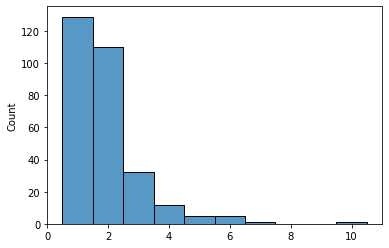

In [109]:
scaf_counts=[]

for bin in rpfilt["bin"].unique():
    scaf_counts.append(len(set(rpfilt[rpfilt["bin"]==bin]["scaffold"])))
    
sns.histplot(scaf_counts, kde=False, discrete=True)
plt.show()

In [117]:
rpiv = rpfilt.pivot(index="bin", columns="ko", values="gene").fillna("None")
# filter out those with inadequate marker counts
rpiv["total"] = rpiv.apply(lambda x: sum([x[col]!='None' for col in rpiv.columns]), axis=1)
rpiv = rpiv[rpiv["total"]>=4].drop("total", axis=1)
rpiv.head(2)

ko,K02874,K02876,K02878,K02881,K02886,K02890,K02895,K02906,K02926,K02931,K02933,K02946,K02961,K02965,K02982,K02994
bin,,,,,,,,,,,,,,,,
2626541536,2626541536_Ga0078726_1005_26,2626541536_Ga0078726_1005_33,2626541536_Ga0078726_1005_23,2626541536_Ga0078726_1005_31,2626541536_Ga0078726_1005_19,2626541536_Ga0078726_1005_21,2626541536_Ga0078726_1005_27,2626541536_Ga0078726_1005_16,2626541536_Ga0078726_1005_17,2626541536_Ga0078726_1005_28,2626541536_Ga0078726_1005_30,None,2626541536_Ga0078726_1005_25,2626541536_Ga0078726_1005_20,2626541536_Ga0078726_1005_22,2626541536_Ga0078726_1005_29
2651870162,None,None,2651870162_Ga0113973_1027_3,None,2651870162_Ga0113973_1027_6,2651870162_Ga0113973_1027_5,None,None,2651870162_Ga0113973_1027_8,None,None,2651870162_Ga0113973_1109_3,2651870162_Ga0113973_1027_1,None,2651870162_Ga0113973_1027_4,None


### align individual genes

In [118]:
outdir = rootdir + "phylo/"

tmp = {record[0].replace(":","_"):record[1] for record in \
          sfp(open(rootdir + "phylo/all_rep_proteins.faa"))}

In [119]:
with open(outdir + "wrapper.sh", "w") as wrapper:
    
    for col in rpiv.columns:
        
        if "K0" in col:
            
            file = outdir + col
            with open(file + ".faa", "w") as faa:
                for key, row in rpiv.iterrows():
                    if row[col] != "None":
                        clean = row[col].replace(":","_")
                        faa.write(">%s\n%s\n" %(clean, tmp[clean]))
                        
            mafft = "mafft %s > %s" %(file + ".faa", file + ".mafft")
            wrapper.write(mafft + "\n")
            
            trim = "trimal -in %s -out %s -gt 0.1" %(file + \
                ".mafft", file + ".trimal.mafft")
            wrapper.write(trim + "\n")    

tmp = {}

In [120]:
aln_lens = {}

for aln in glob.glob(rootdir + "phylo/*trimal*"):
    gene = os.path.basename(aln).split(".")[0]
    tmp[gene] = {}
    for record in sfp(open(aln)):
        tmp[gene][record[0]] = record[1]
    aln_lens[gene] = len(record[1])
        
with open(rootdir + "phylo/rp16.mafft", "w") as out:
    for key, row in rpiv.iterrows():
        out.write(">%s\n" %(key))
        for col in rpiv.columns:
            if row[col] == "None":
                out.write("-"*aln_lens[col])
            else:
                clean = row[col].replace(":","_")
                out.write(tmp[col][clean])
        out.write("\n")

tmp = {}

### tree + annotation

In [121]:
palette = {"HL I": "blue", "HL II" :"blue", "HL III":"blue", "HL III/IV": "blue", "HL IV": "blue",
           "LL IV": "green", "LL I": "lightgreen", "LL II": "lightgreen", "LL III": "lightgreen", "LL II/III": "lightgreen",
           "5.1": "purple", "5.1A":"purple", "5.1B":"purple", "5.2":"purple", "5.3":"purple", 
           "AMZ IA" : "red", "AMZ IB": "orange", "AMZ II":"yellow", "AMZ III":"pink", "unaffiliated": "lightgrey"}

In [122]:
#FASTREE
cmd = "FastTreeMP %s > %s" %(rootdir + "phylo/rp16.mafft",
                            rootdir + "phylo/rp16.tre")
#IQTREE
tree = "iqtree2 -s %s -bnni -m TEST -st AA -bb 1000 --threads-max 20 -nt AUTO -pre %s" %(rootdir + \
    "phylo/rp16.mafft", rootdir + "phylo/rp16")
print(sbatch("iqtree", 20, tree))

sbatch -J iqtree -p serc -t 1- -c 20 --mem 160G --wrap 'iqtree2 -s /scratch/users/ajaffe/photoeco/phylo/rp16.mafft -bnni -m TEST -st AA -bb 1000 --threads-max 20 -nt AUTO -pre /scratch/users/ajaffe/photoeco/phylo/rp16'


In [123]:
# annotate
itol = open(rootdir + "phylo/rp16.itol.txt", "w")
itol.write("TREE_COLORS\nSEPARATOR TAB\nDATA\n")

for key, row in genomes.iterrows():
    color = palette[row["lineage"]]
    label = row["lineage"]
    itol.write(row["genome_name"] + "\trange\t" + color + "\t" + label + "\n")
    
itol.close()

In [137]:
# rubiscos and stuff
itol = open(rootdir + "phylo/dataset.itol.txt", "w")
itol.write("DATASET_BINARY\nSEPARATOR COMMA\nDATASET_LABEL,rubiscos\nCOLOR,#ff0000\n")
itol.write("FIELD_SHAPES,1,1,1,2,2\n")
itol.write("FIELD_LABELS,isolate,this,type,formI,formII\n")
itol.write("FIELD_COLORS,back,black,black,green,blue\nDATA\n")
    
#for cluster in genomes["cluster99"].unique():
for key, row in pd.read_csv(rootdir + "supp/table_s1_curated.tsv",sep="\t").iterrows():

    #table = genomes[genomes["cluster99"]==cluster].sort_values("checkm_completeness", ascending=False)
    #genes = rubiscos[rubiscos["genome_name"].isin(table["genome_name"].to_list())]["hmm"].unique()
    genes = rubiscos[rubiscos["genome_name"]==row["genome_name"]]["hmm"].unique()
    
    #representative = table["genome_name"].iloc[0]
    
    if row["genome_type"] == "MAG":
        gtype = 1
    elif row["genome_type"] in ["SAG", "isolate"]:
        gtype = 0
    else: gtype = -1
        
    isolate = 1 if row["genome_type"] == "isolate" else 0
    this = 1 if "RR" in row["genome_name"] else 0
    
    one = 1 if "I" in genes else -1
    two = 1 if "II" in genes else -1
    itol.write("%s,%d,%d,%d,%d,%d\n" %(row["genome_name"], isolate,this,gtype, one, two))
    #itol.write("%s,%d,%d\n" %(representative, one, two))
    
itol.close()

## misc

In [11]:
s2 = kresults[kresults["def"].str.contains("subunit ribosomal protein S2$")]
s2["scaffold"] = s2["gene"].apply(lambda x: "_".join(x.split("_")[:-1]))
s2["bin"] = s2["scaffold"].map(scaf2bin)

with open(rootdir + "phylo/s2.faa", "w") as out:
    
    for key, row in s2.sort_values("score", ascending=False).drop_duplicates("bin").iterrows():
        clean = row["gene"].replace(":","_")
        out.write(">%s\n%s\n" %(clean, tmp[clean]))